In [13]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from IPython.display import HTML
from collections import OrderedDict
import h5py
%matplotlib inline
torch.manual_seed(1)
pd.set_option("display.precision", 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preprocessing

In [2]:
# Load Data
SFX_BTC_df = pd.read_csv(f'data/SFX_BTC_minute.csv')
BTC_RSD_df = pd.read_csv(f'data/BTC_RSD_minute.csv')
ETH_BTC_df = pd.read_csv(f'data/ETH_BTC_minute.csv')
ETH_RSD_df = pd.read_csv(f'data/ETH_RSD_minute.csv')
SFT_RSD_df = pd.read_csv(f'data/SFT_RSD_minute.csv')
SFX_RSD_df = pd.read_csv(f'data/SFX_RSD_minute.csv')

# Make example dataframe for our timerange to make sure we don't have any duplicates
empty_daterange = pd.date_range(start='2019-06-26 00:00', end='2020-05-25 00:00', freq='T')
df = pd.DataFrame(index=empty_daterange, columns=['A'])
display(df)

# Load data into dictionary to make it easier to create the master dataframe later
df_dict = {'SFX_BTC': SFX_BTC_df, 
           'BTC_RSD': BTC_RSD_df, 
           'ETH_BTC': ETH_BTC_df, 
           'ETH_RSD': ETH_RSD_df, 
           'SFT_RSD': SFT_RSD_df, 
           'SFX_RSD': SFX_RSD_df}

# Sort by longest to preserve data when aligning with example df
df_dict = OrderedDict(sorted(df_dict.items(), key=len, reverse=True))

for i, k in enumerate(df_dict):
    # Set index to datetime
    df_dict[k].index = pd.to_datetime(df_dict[k]['timestamp']).rename('').dt.tz_localize(None)
    # Drop timestamp axis since we already used set it to the index
    df_dict[k].drop(['timestamp'], axis=1, inplace=True)
    # Fill NA values with the previous row
    df_dict[k].fillna(method='ffill', inplace=True)
    # Normalize DF length
    df_dict[k] = df_dict[k]['2019-06-26 00:00':'2020-05-25 00:00']
    # Align Dates
    _, df_dict[k] = df.align(df_dict[k], join='inner', axis=0, method='ffill')
    # Fill the NA quantity values
    df_dict[k]['quantity'].fillna(0, inplace=True)
    # Remove duplicate indices
    df_dict[k] = df_dict[k].loc[~df_dict[k].index.duplicated(keep='last')]
    display(df_dict[k])


,A
2019-06-26 00:00:00,NaN
2019-06-26 00:01:00,NaN
2019-06-26 00:02:00,NaN
2019-06-26 00:03:00,NaN
2019-06-26 00:04:00,NaN
...,...
2020-05-24 23:56:00,NaN
2020-05-24 23:57:00,NaN
2020-05-24 23:58:00,NaN
2020-05-24 23:59:00,NaN


,open,high,low,close,count,volume,quantity
2019-06-26 00:00:00,0.00000400,0.00000400,0.00000400,0.00000400,0,0.0,0.0
2019-06-26 00:01:00,0.00000400,0.00000400,0.00000400,0.00000400,0,0.0,0.0
2019-06-26 00:02:00,0.00000400,0.00000400,0.00000400,0.00000400,0,0.0,0.0
2019-06-26 00:03:00,0.00000400,0.00000400,0.00000400,0.00000400,0,0.0,0.0
2019-06-26 00:04:00,0.00000400,0.00000400,0.00000400,0.00000400,0,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-24 23:56:00,0.00000137,0.00000137,0.00000137,0.00000137,0,0.0,0.0
2020-05-24 23:57:00,0.00000137,0.00000137,0.00000137,0.00000137,0,0.0,0.0
2020-05-24 23:58:00,0.00000137,0.00000137,0.00000137,0.00000137,0,0.0,0.0
2020-05-24 23:59:00,0.00000137,0.00000137,0.00000137,0.00000137,0,0.0,0.0


,open,high,low,close,count,volume,quantity
2019-06-26 00:00:00,9.64459735e+05,9.64459735e+05,9.64459735e+05,9.64459735e+05,0,0.0,0.0
2019-06-26 00:01:00,9.64459735e+05,9.64459735e+05,9.64459735e+05,9.64459735e+05,0,0.0,0.0
2019-06-26 00:02:00,9.64459735e+05,9.64459735e+05,9.64459735e+05,9.64459735e+05,0,0.0,0.0
2019-06-26 00:03:00,9.64459735e+05,9.64459735e+05,9.64459735e+05,9.64459735e+05,0,0.0,0.0
2019-06-26 00:04:00,9.64459735e+05,9.64459735e+05,9.64459735e+05,9.64459735e+05,0,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-24 23:56:00,1.19999800e+06,1.19999800e+06,1.19999800e+06,1.19999800e+06,0,0.0,0.0
2020-05-24 23:57:00,1.19999800e+06,1.19999800e+06,1.19999800e+06,1.19999800e+06,0,0.0,0.0
2020-05-24 23:58:00,1.19999800e+06,1.19999800e+06,1.19999800e+06,1.19999800e+06,0,0.0,0.0
2020-05-24 23:59:00,1.19999800e+06,1.19999800e+06,1.19999800e+06,1.19999800e+06,0,0.0,0.0


,open,high,low,close,count,volume,quantity
2019-06-26 00:00:00,0.03020000,0.03020000,0.03020000,0.03020000,0,0.0,0.0
2019-06-26 00:01:00,0.03020000,0.03020000,0.03020000,0.03020000,0,0.0,0.0
2019-06-26 00:02:00,0.03020000,0.03020000,0.03020000,0.03020000,0,0.0,0.0
2019-06-26 00:03:00,0.03020000,0.03020000,0.03020000,0.03020000,0,0.0,0.0
2019-06-26 00:04:00,0.03020000,0.03020000,0.03020000,0.03020000,0,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-24 23:56:00,0.02894139,0.02894139,0.02894139,0.02894139,0,0.0,0.0
2020-05-24 23:57:00,0.02894139,0.02894139,0.02894139,0.02894139,0,0.0,0.0
2020-05-24 23:58:00,0.02894139,0.02894139,0.02894139,0.02894139,0,0.0,0.0
2020-05-24 23:59:00,0.02894139,0.02894139,0.02894139,0.02894139,0,0.0,0.0


,open,high,low,close,count,volume,quantity
2019-06-26 00:00:00,29000.00000000,29000.00000000,29000.00000000,29000.00000000,0,0.0,0.0
2019-06-26 00:01:00,29000.00000000,29000.00000000,29000.00000000,29000.00000000,0,0.0,0.0
2019-06-26 00:02:00,29000.00000000,29000.00000000,29000.00000000,29000.00000000,0,0.0,0.0
2019-06-26 00:03:00,29000.00000000,29000.00000000,29000.00000000,29000.00000000,0,0.0,0.0
2019-06-26 00:04:00,29000.00000000,29000.00000000,29000.00000000,29000.00000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-24 23:56:00,26999.98999999,26999.98999999,26999.98999999,26999.98999999,0,0.0,0.0
2020-05-24 23:57:00,26999.98999999,26999.98999999,26999.98999999,26999.98999999,0,0.0,0.0
2020-05-24 23:58:00,26999.98999999,26999.98999999,26999.98999999,26999.98999999,0,0.0,0.0
2020-05-24 23:59:00,26999.98999999,26999.98999999,26999.98999999,26999.98999999,0,0.0,0.0


,open,high,low,close,count,volume,quantity
2019-06-26 00:00:00,19.00000000,19.00000000,19.00000000,19.00000000,0,0.0,0.0
2019-06-26 00:01:00,19.00000000,19.00000000,19.00000000,19.00000000,0,0.0,0.0
2019-06-26 00:02:00,19.00000000,19.00000000,19.00000000,19.00000000,0,0.0,0.0
2019-06-26 00:03:00,19.00000000,19.00000000,19.00000000,19.00000000,0,0.0,0.0
2019-06-26 00:04:00,19.00000000,19.00000000,19.00000000,19.00000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-24 23:56:00,0.72499999,0.72499999,0.72499999,0.72499999,0,0.0,0.0
2020-05-24 23:57:00,0.72499999,0.72499999,0.72499999,0.72499999,0,0.0,0.0
2020-05-24 23:58:00,0.72499999,0.72499999,0.72499999,0.72499999,0,0.0,0.0
2020-05-24 23:59:00,0.72499999,0.72499999,0.72499999,0.72499999,0,0.0,0.0


,open,high,low,close,count,volume,quantity
2019-06-26 00:00:00,36.90000000,36.90000000,36.90000000,36.90000000,0,0.0,0.0
2019-06-26 00:01:00,36.90000000,36.90000000,36.90000000,36.90000000,0,0.0,0.0
2019-06-26 00:02:00,36.90000000,36.90000000,36.90000000,36.90000000,0,0.0,0.0
2019-06-26 00:03:00,36.90000000,36.90000000,36.90000000,36.90000000,0,0.0,0.0
2019-06-26 00:04:00,36.90000000,36.90000000,36.90000000,36.90000000,0,0.0,0.0
...,...,...,...,...,...,...,...
2020-05-24 23:56:00,1.74999986,1.74999986,1.74999986,1.74999986,0,0.0,0.0
2020-05-24 23:57:00,1.74999986,1.74999986,1.74999986,1.74999986,0,0.0,0.0
2020-05-24 23:58:00,1.74999986,1.74999986,1.74999986,1.74999986,0,0.0,0.0
2020-05-24 23:59:00,1.74999986,1.74999986,1.74999986,1.74999986,0,0.0,0.0


In [3]:
dataset_df = pd.DataFrame(index=['SFX_BTC', 'BTC_RSD', 'ETH_BTC', 
                                 'ETH_RSD', 'SFT_RSD', 'SFX_RSD'], 
                          columns=SFX_BTC_df.columns)
for i, k in enumerate(df_dict):
    dataset_df.loc[k] = pd.Series({'open':df_dict[k]['open'].to_numpy(),
                                   'high':df_dict[k]['high'].to_numpy(),
                                   'low':df_dict[k]['low'].to_numpy(), 
                                   'close':df_dict[k]['close'].to_numpy(),
                                   'count':df_dict[k]['count'].to_numpy(),
                                   'volume':df_dict[k]['volume'].to_numpy(),
                                   'quantity':df_dict[k]['quantity'].to_numpy()})


In [4]:
dataset_df

,open,high,low,close,count,volume,quantity
SFX_BTC,"[4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-...","[4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-...","[4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-...","[4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-06, 4e-...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
BTC_RSD,"[964459.73547203, 964459.73547203, 964459.7354...","[964459.73547203, 964459.73547203, 964459.7354...","[964459.73547203, 964459.73547203, 964459.7354...","[964459.73547203, 964459.73547203, 964459.7354...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ETH_BTC,"[0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.030...","[0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.030...","[0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.030...","[0.0302, 0.0302, 0.0302, 0.0302, 0.0302, 0.030...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ETH_RSD,"[29000.0, 29000.0, 29000.0, 29000.0, 29000.0, ...","[29000.0, 29000.0, 29000.0, 29000.0, 29000.0, ...","[29000.0, 29000.0, 29000.0, 29000.0, 29000.0, ...","[29000.0, 29000.0, 29000.0, 29000.0, 29000.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
SFT_RSD,"[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....","[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....","[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....","[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
SFX_RSD,"[36.9, 36.9, 36.9, 36.9, 36.9, 36.9, 36.9, 36....","[36.9, 36.9, 36.9, 36.9, 36.9, 36.9, 36.9, 36....","[36.9, 36.9, 36.9, 36.9, 36.9, 36.9, 36.9, 36....","[36.9, 36.9, 36.9, 36.9, 36.9, 36.9, 36.9, 36....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
def create_x(input_df, window_size):
    close_value = np.stack(input_df['close'].to_numpy(), axis=1)[:-1]
    open_value = np.stack(input_df['open'].to_numpy(), axis=1)[:-1]
    high_value = np.stack(input_df['high'].to_numpy(), axis=1)[:-1]
    low_value = np.stack(input_df['low'].to_numpy(), axis=1)[:-1]
    V_t = (open_value/close_value[-1])
    V_t_high = (high_value/close_value[-1])
    V_t_low = (low_value/close_value[-1])
    X_t = torch.from_numpy(np.stack([V_t, V_t_high, V_t_low], axis=1)).T
    X_t = np.split(X_t, window_size, axis=2)
    return X_t

In [365]:
# Create our input
X = create_x(dataset_df, 167)
X_test = X[-int(len(X)*0.20):]
X_train = X[:-int(len(X)*0.20)]

# Create our inital weights
W_0 = torch.zeros(6, 1, 1, 1).double()
# Set first value to 1 as described in the paper
W_0[0] = 1

# Create our cash bias
cash_bias = torch.ones(1).double()

# Create our dataloaders
test_loader = DataLoader(X_test, batch_size=8)
train_loader = DataLoader(X_train, batch_size=8)

In [366]:
print(f'cash_bias shape is :{cash_bias.shape}')
print(f'inital weight shape is: {W_0.shape}')
print(f'training input tensor shape is: {X_train[0].shape}')

cash_bias shape is :torch.Size([1])
inital weight shape is: torch.Size([6, 1, 1, 1])
training input tensor shape is: torch.Size([6, 3, 2880])


In [367]:
X_train

[tensor([[[ 2.9197,  2.9197,  2.9197,  ...,  2.9197,  2.9197,  2.9197],
          [ 2.9197,  2.9197,  2.9197,  ...,  2.9197,  2.9197,  2.9197],
          [ 2.9197,  2.9197,  2.9197,  ...,  2.9197,  2.9197,  2.9197]],
 
         [[ 0.8037,  0.8037,  0.8037,  ...,  1.2204,  1.2204,  1.2204],
          [ 0.8037,  0.8037,  0.8037,  ...,  1.2204,  1.2204,  1.2204],
          [ 0.8037,  0.8037,  0.8037,  ...,  1.2204,  1.2204,  1.2204]],
 
         [[ 1.0435,  1.0435,  1.0435,  ...,  1.0435,  1.0435,  1.0435],
          [ 1.0435,  1.0435,  1.0435,  ...,  1.0435,  1.0435,  1.0435],
          [ 1.0435,  1.0435,  1.0435,  ...,  1.0435,  1.0435,  1.0435]],
 
         [[ 1.0741,  1.0741,  1.0741,  ...,  1.0741,  1.0741,  1.0741],
          [ 1.0741,  1.0741,  1.0741,  ...,  1.0741,  1.0741,  1.0741],
          [ 1.0741,  1.0741,  1.0741,  ...,  1.0741,  1.0741,  1.0741]],
 
         [[26.2069, 26.2069, 26.2069,  ...,  1.6552,  1.6552,  1.6552],
          [26.2069, 26.2069, 26.2069,  ...,  1.6552,

In [368]:
# TODO
with h5py.File('dataset.hdf5', 'a') as f:
    f.create_dataset('X_train', data=X_train.numpy(), compression='gzip')
    f.create_dataset('X_test', data=X_test.numpy(), compression='gzip')

AttributeError: 'list' object has no attribute 'numpy'

## Model

![cnn_diagram](https://i.stack.imgur.com/m4JE9.png)

This is the diagram cited in the paper for the CNN architecture. Our model will obviously not match the same the same dimentions as the one in the paper but this is pretty much what we're going for.

In [369]:
# Some things to set when starting
commision_ratio = 0.0025

DPM_CNN(
  (conv1): Conv2d(3, 2, kernel_size=(1, 20), stride=(1, 1))
  (conv2): Conv2d(2, 20, kernel_size=(1, 2861), stride=(1, 1))
  (conv3): Conv2d(21, 1, kernel_size=(1, 1), stride=(1, 1))
  (softmax): Softmax(dim=None)
)


/home/collin/.virtualenvs/safex_trading_bot/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


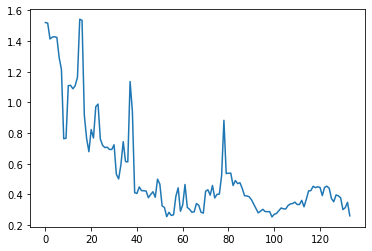

In [412]:
# Create our input
X = create_x(dataset_df, 167)
X_test = X[-int(len(X)*0.20):]
X_train = X[:-int(len(X)*0.20)]

# Create our inital weights
W_0 = torch.zeros(6, 1, 1, 1).double()
# Set first value to 1 as described in the paper
W_0[0] = 1

# Create our cash bias
cash_bias = torch.ones(1).double()

class DPM_CNN(torch.nn.Module):
    def __init__(self, cash_bias):
        super().__init__()
        self.cash_bias = cash_bias
        self.conv1 = nn.Conv2d(3, 2, kernel_size=(1,20))
        self.conv2 = nn.Conv2d(2, 20, kernel_size=(1,2861))
        self.conv3 = nn.Conv2d(21, 1, kernel_size=(1, 1))
        self.softmax = nn.Softmax()

    def forward(self, x, w_last):
        #print(f'input: {x.shape}')
        x = F.relu(self.conv1(x))
        #print(f'conv2d 1: {x.shape}')
        x = F.relu(self.conv2(x))
        #print(f'conv2d 2: {x.shape}')
        #print(f'w_last shape: {w_last.shape}')
        x = torch.cat((x, w_last), axis=1)
        #print(f'cat x and w_last: {x.shape}')
        x = F.relu(self.conv3(x))
        #print(f'conv2d 3: {x.shape}')
        x = torch.flatten(x)
        #print(f'flatten: {x.shape}')
        x = torch.cat((x, self.cash_bias), axis=-1)
        #print(f'cat x and cash_bias: {x.shape}')
        w = self.softmax(x)
        #print(f'softmax output weights: {w}')
        return w

model = DPM_CNN(cash_bias).double()
opt = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print(model)

def custom_loss(output, future_price, w_last):
    mew = torch.sum(torch.abs(output[1:] - torch.squeeze(w_last)), dim=0, keepdim=True) * commision_ratio
    loss = torch.mean(torch.log(torch.sum(output[:]*future_price, dim=0) - mew))
    return loss

epochs=1
running_loss = []
for epoch in range(epochs):
    for i in range(len(X_train)):
        if i==0:
            w_last = W_0
        else:
            w_last.data = torch.reshape(w[1:], (w[1:].shape[0],1,1,1))
        w = model(torch.unsqueeze(X_train[i], 2), w_last.data)
        y = torch.cat((torch.ones([6,1]).double(), X_train[i][:, 0, -1:]), dim=0)
        loss = custom_loss(w, y, w_last.data)
        opt.step()
        running_loss.append(loss.item())
plt.plot(running_loss)

In [413]:
model.eval()
model(torch.unsqueeze(X_test[3], 2), w_last)

/home/collin/.virtualenvs/safex_trading_bot/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([0.1189, 0.1176, 0.1197, 0.1176, 0.1170, 0.1208, 0.2884],
       dtype=torch.float64, grad_fn=<SoftmaxBackward>)